In [5]:
import fastf1 as ff1
import numpy as np
import pandas as pd

def timedelta_to_seconds(td):
    return td.total_seconds()

session = ff1.get_session(2022, 'Imola', 'R')
session.load()

def get_data(driver, session):
    session_driver = session.laps.pick_driver(driver)
    driver_lap_number = session_driver['LapNumber'] # Driver's lap
    driver_sector1_time = (session_driver['Sector1Time'] / np.timedelta64(1, 's')).astype(float) # Sector 1 recorded time
    driver_sector2_time = (session_driver['Sector2Time'] / np.timedelta64(1, 's')).astype(float) # Sector 2 recorded time
    driver_sector3_time = (session_driver['Sector3Time'] / np.timedelta64(1, 's')).astype(float) # Sector 3 recorded time
    driver_lap_time = session_driver['LapTime'].apply(timedelta_to_seconds)
    weather_rainfall = session.laps.get_weather_data()['Rainfall'] #Shows if there is rainfall
    weather_rainfall = np.where(weather_rainfall == True, 1, 0)
    weather_track_temperature = session.laps.get_weather_data()['TrackTemp'] # Track temperature [Celsius]
    driver_list = [driver] * len(driver_lap_number)
    grand_prix_list = [session.event['Location']] * len(driver_lap_number)
    compound = session_driver['Compound']
    list_of_tuples = list(zip(driver_list, grand_prix_list,driver_lap_number, driver_sector1_time, driver_sector2_time,driver_sector3_time, driver_lap_time, weather_rainfall,weather_track_temperature, compound))
    df = pd.DataFrame(list_of_tuples, columns = ['Driver', 'Race', 'Lap', 'Sector 1 Time', 'Sector 2 Time', 'Sector 3 Time', 'LapTime', 'Rainfall', 'Track Temp', 'Compound'])
    return df

req         WARNING 	DEFAULT CACHE ENABLED! (2.79 GB) C:\Users\dilau\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.4.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '

In [6]:
# Define dict_data with necessary mappings
dict_data = {
    'drivers': {
        # Add driver mappings here
    },
    'races': {
        # Add race mappings here
    },
    'compound': {
        # Add compound mappings here
    }
}

def load_dataset(year_list):
    driver_race_data_list = []
    driver_encoding = {}
    race_encoding = {}
    compound_encoding = {}
    for year in year_list:
        # Get the race list for the input year
        race_list = get_race_list(year)
        driver_race_data = {}
        for race in race_list:
            session = ff1.get_session(year, race, 'R')
            session.load()
            driver_list = pd.unique(session.laps['Driver'])
            for driver in driver_list:
                session_driver = session.laps.pick_driver(driver)
                # Load all the driver's information for the current
                session
                data = get_data(driver, session)
                # Encode and replace driver data.
                driver_encoding[driver] = dict_data['drivers'].get(driver, -1)
                driver_encoded = driver_encoding[driver]
                data['Driver'] = data['Driver'].replace(driver, driver_encoded)
                 # Encode and replace race data.
                race_encoding[race] = dict_data['races'].get(race, -1)
                race_encoded = race_encoding[race]
                data['Race'] = data['Race'].replace(race, race_encoded)
                # Compound's driver data from fastf1 library.
                compound_list = session_driver['Compound']
                for compound in compound_list:
                    # Encode and replace compound data.
                    compound_encoding[compound] = dict_data['compound'].get(compound, -1)
                    compound_encoded = compound_encoding[compound]
                    data['Compound'] = data['Compound'].replace(compound, compound_encoded)
                    driver_race_data[(driver_encoded, race_encoded)] = data.values
                    # Add rows until lap is equal to 78 (Monaco's grand prix lap).
                    while(driver_race_data[(driver_encoded, race_encoded)].shape[0] < 78):
                        lap = driver_race_data[(driver_encoded, race_encoded)].shape[0] + 1
                        new_row = np.array([[driver_encoded, race_encoded, lap, -1, -1, -1, -1, -1, -1, -1]])
                        driver_race_data[(driver_encoded, race_encoded)] = np.vstack((driver_race_data[(driver_encoded, race_encoded)], new_row))

        # Replace NaN values with -1
        for key, value in driver_race_data.items():
            driver_race_data[key] = np.nan_to_num(value, nan=-1)
        
        driver_race_data_list.append(driver_race_data)

    return driver_race_data_list

In [2]:
def get_race_list(year):
    grand_prix_list = ff1.get_event_schedule(year)
    race_list = []

    for race in grand_prix_list['Location']:
        race_list.append(race)
    
    # Removing Pre-season test sessions.
    if year == 2022:
        race_list.remove('Spain')
        race_list.remove('Bahrain')
    elif year == 2021:
        race_list.remove('Sakhir')
    elif year == 2020:
        race_list.remove('Montmelo')
        race_list.remove('Montmelo')
                         
    return race_list

In [7]:
def generate_dataset(year_list):
    driver_race_data_list = load_dataset(year_list)
    # Determine the shape of the 3D numpy array
    m, n = next(iter(driver_race_data_list[0].values())).shape
    N = sum(len(d) for d in driver_race_data_list)
    full_dataset = np.zeros((N, m, n))
    # Convert each dictionary to a 3D numpy array and stack them
    i = 0
    for dataset in driver_race_data_list:
        for key, value in dataset.items():
            full_dataset[i] = value
            i += 1
    # Save the full dataset to a file
    np.save('ex1_data.csv', full_dataset)

    return full_dataset

In [8]:
generate_dataset([2024])

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
c:\Users\dilau\Desktop\TeamProjF1\FASTF1\.venv\Lib\site-packag

array([[[ -1.   ,  -1.   ,   1.   ,  -1.   ,  40.179,  33.61 , 103.757,
           0.   ,  32.1  ,  -1.   ],
        [ -1.   ,  -1.   ,   2.   ,  18.638,  58.714,  44.564, 121.916,
           0.   ,  32.2  ,  -1.   ],
        [ -1.   ,  -1.   ,   3.   ,  20.038,  40.515,  34.307,  94.86 ,
           0.   ,  31.8  ,  -1.   ],
        [ -1.   ,  -1.   ,   4.   ,  18.474,  38.48 ,  35.247,  92.201,
           0.   ,  31.9  ,  -1.   ],
        [ -1.   ,  -1.   ,   5.   ,  40.033,  38.421,  32.433, 110.887,
           0.   ,  31.7  ,  -1.   ],
        [ -1.   ,  -1.   ,   6.   ,  18.106,  38.347,  32.497,  88.95 ,
           0.   ,  31.8  ,  -1.   ],
        [ -1.   ,  -1.   ,   7.   ,  18.083,  38.478,  32.591,  89.152,
           0.   ,  31.8  ,  -1.   ],
        [ -1.   ,  -1.   ,   8.   ,  18.21 ,  38.424,  32.848,  89.482,
           0.   ,  31.5  ,  -1.   ],
        [ -1.   ,  -1.   ,   9.   ,  18.128,  38.415,  33.01 ,  89.553,
           0.   ,  31.6  ,  -1.   ],
        [ -1.   ,  

c:\Users\dilau\Desktop\TeamProjF1\FASTF1\.venv\Lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
c:\Users\dilau\Desktop\TeamProjF1\FASTF1\.venv\Lib\site-packages\fastf1\plotting\_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(
c:\Users\dilau\Desktop\TeamProjF1\FASTF1\.venv\Lib\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"{name} is deprecated and will be removed in a future "


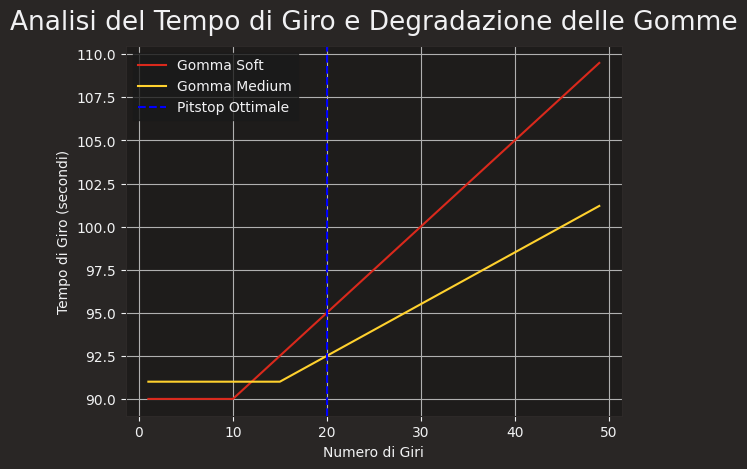

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import fastf1.plotting

# Define the lap numbers
giri = np.arange(1, 50)

# Simulate lap times for Soft and Medium tires
tempo_soft = 90 + 0.5 * np.maximum(0, giri - 10)  # Soft tires degrade faster
tempo_medium = 91 + 0.3 * np.maximum(0, giri - 15)  # Medium tires degrade slower

# Set up FastF1's Matplotlib style
fastf1.plotting.setup_mpl()

# Get the official compound colors
compound_colors = fastf1.plotting.COMPOUND_COLORS

# Plot the lap times with compound colors
plt.plot(giri, tempo_soft, label='Gomma Soft', color=compound_colors["SOFT"])
plt.plot(giri, tempo_medium, label='Gomma Medium', color=compound_colors["MEDIUM"])

# Add a vertical line for the optimal pit stop
plt.axvline(x=20, color='b', linestyle='--', label='Pitstop Ottimale')

# Add labels and title
plt.xlabel('Numero di Giri')
plt.ylabel('Tempo di Giro (secondi)')
plt.title('Analisi del Tempo di Giro e Degradazione delle Gomme')

# Add a legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()